In [4]:
import numpy as np
from numpy import newaxis
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import completed


In [5]:
data = pd.read_excel("/content/dataset_input_1.xlsx", sheet_name="Sheet1")
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
n_features = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], n_features, 1)
X_val = X_val.reshape(X_val.shape[0], n_features, 1)
X_test = X_test.reshape(X_test.shape[0], n_features, 1)
print("X_train shape:", X_train.shape)  # Check the shape of X_train
print("X_train shape after reshaping:", X_train.shape)

X_train shape: (5517, 25, 1)
X_train shape after reshaping: (5517, 25, 1)


In [21]:
model = Sequential()
model.add(Input(shape=(n_features, 1)))
model.add(Conv1D(128, kernel_size=5, activation="relu", padding = 'same'))
model.add(Conv1D(64, kernel_size=3, activation="relu", padding = 'same'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(32, kernel_size=2, activation="relu", padding = 'same'))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(10, activation="relu"))

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 25, 128)           768       
                                                                 
 conv1d_22 (Conv1D)          (None, 25, 64)            24640     
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 12, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_23 (Conv1D)          (None, 12, 32)            4128      
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 6, 32)             0         
 ng1D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 192)              

In [22]:
model.compile(optimizer='SGD', loss='mean_absolute_error')
history = model.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=1000,
    epochs=100  # Don't forget to include your callbacks
)

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Epoch 1/100
6/6 [==============================] - 2s 161ms/step - loss: 13.9282 - val_loss: 9.6594
Epoch 2/100
6/6 [==============================] - 1s 132ms/step - loss: 9.7624 - val_loss: 9.6602
Epoch 3/100
6/6 [==============================] - 1s 128ms/step - loss: 9.7260 - val_loss: 9.6560
Epoch 4/100
6/6 [==============================] - 1s 129ms/step - loss: 9.5400 - val_loss: 8.6280
Epoch 5/100
6/6 [==============================] - 1s 125ms/step - loss: 9.0209 - val_loss: 7.5132
Epoch 6/100
6/6 [==============================] - 1s 189ms/step - loss: 7.9910 - val_loss: 5.4545
Epoch 7/100
6/6 [==============================] - 1s 217ms/step - loss: 6.3852 - val_loss: 4.0882
Epoch 8/100
6/6 [==============================] - 1s 201ms/step - loss: 6.1064 - val_loss: 3.5890
Epoch 9/100
6/6 [==============================] - 1s 142ms/step - loss: 5.6564 - val_loss: 3.1348
Epoch 10/100
6/6 [==============================] - 1s 143ms/step - loss: 5.1697 - val_loss: 3.2013
Epoch 11

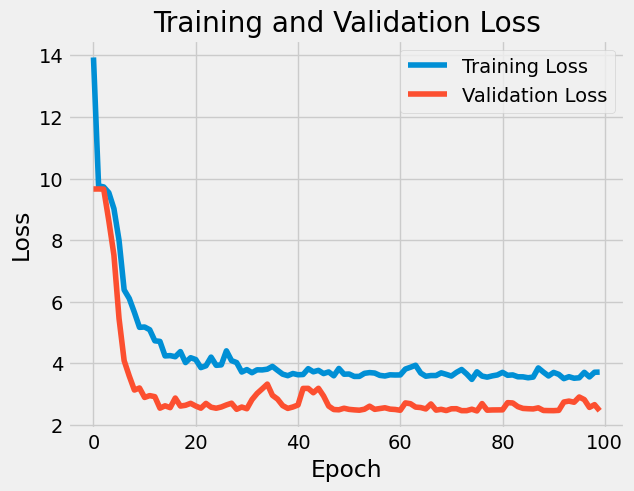

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [26]:
predictions = model.predict(X_test)

actual_values = []
predicted_values = []

# Iterate through each element in y_test and its corresponding prediction
for actual, prediction in zip(y_test.flatten(), predictions.flatten()):
    actual_values.append(actual)
    predicted_values.append(prediction)

# Create DataFrame for comparison
comparison_df = pd.DataFrame({'Actual': actual_values, 'Predicted': predicted_values})
print(comparison_df.head(len(predictions)))  # Display first 10 rows for comparison

62/62 [==============================] - 1s 11ms/step
         Actual  Predicted
0      8.330000   8.432557
1      9.710000   8.409946
2     10.000000   8.510693
3     11.260000   8.457903
4      7.140000   8.430494
...         ...        ...
1966  13.790000   8.975269
1967   6.660000   9.357395
1968   8.700000   9.095380
1969  18.870001   9.334984
1970   8.200000   8.742508

[1971 rows x 2 columns]


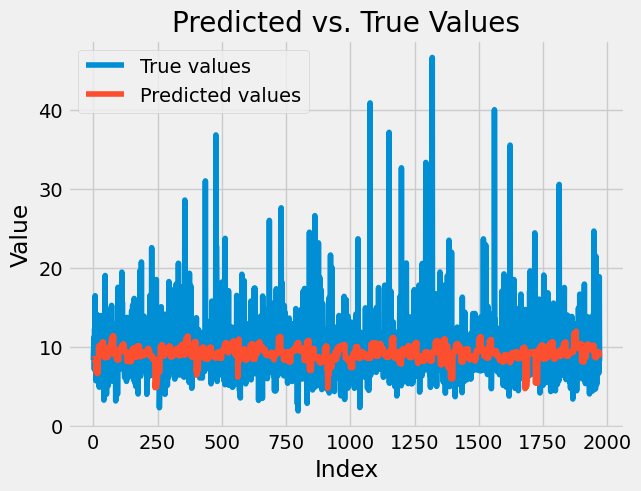

In [28]:
plt.plot(y_test, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values")
plt.legend()
plt.show()